<h1 style="color:#d38f0f; text-align:center">Used cars price prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import json
import pickle

In [2]:
df = pd.read_csv('cardekho_imputated.csv')
df.head()

,Unnamed: 0,car_name,brand,model,min_cost_price,max_cost_price,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
0,0,Maruti Alto,Maruti,Alto,3.570039e+05,4.654015e+05,9,120000,Individual,Petrol,Manual,19.70,796,46.30,5,120000
1,1,Hyundai Grand,Hyundai,Grand,7.110000e+05,7.480000e+05,5,20000,Individual,Petrol,Manual,18.90,1197,82.00,5,550000
2,2,Hyundai i20,Hyundai,i20,8.540829e+05,1.307926e+06,11,60000,Individual,Petrol,Manual,17.00,1197,80.00,5,215000
3,3,Maruti Alto,Maruti,Alto,3.570039e+05,4.654015e+05,9,37000,Individual,Petrol,Manual,20.92,998,67.10,5,226000
4,4,Ford Ecosport,Ford,Ecosport,1.014000e+06,1.379000e+06,6,30000,Dealer,Diesel,Manual,22.77,1498,98.59,5,570000


In [3]:
brand_model = df[['brand', 'model']].drop_duplicates()
unique_brands = brand_model.brand.unique()
d=dict()
l=list()
for i in range(len(unique_brands)):
    d.setdefault(unique_brands[i], [])
    l.append([brand_model[brand_model.brand == unique_brands[i]]['model']])
    d[unique_brands[i]]=l[i]

In [4]:
dc=dict()
for i in range(len(unique_brands)):
    dc.setdefault(unique_brands[i], [])
for i in range(len(d.values())):
    for j in list(d.values())[i]:
        ls = list(j)
        dc[unique_brands[i]] = ls
# print(dc)

with open('brand_model.json', 'w') as f:
    f.write(json.dumps(dc))

In [5]:
df.drop(['Unnamed: 0', 'seller_type'], axis=1, inplace=True)

In [6]:
df.drop(df[(df['vehicle_age'] > 20) ].index, inplace=True)
df.drop(df[df['km_driven'] >300000 ].index, inplace=True)

In [7]:
df['avg_cost_price']=(df['min_cost_price']+df['max_cost_price'])/2
df.drop(['min_cost_price', 'max_cost_price'], axis=1, inplace=True)

In [8]:
df = pd.get_dummies(df, columns=['fuel_type','transmission_type','brand','model'],drop_first=True, prefix="", prefix_sep="")

In [9]:
df.drop('car_name', axis=1, inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
X=df.drop(columns=['selling_price'],axis=1)
y=df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [11]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaled_X_train = std_scaler.fit_transform(X_train)

In [12]:
scaled_X_test = std_scaler.transform(X_test)

In [13]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

CV = []
R2_train = []
R2_test = []

In [14]:
rfr = RandomForestRegressor()
rfr.fit(scaled_X_train, y_train)

y_pred_train = rfr.predict(scaled_X_train)
R2_train_model = r2_score(y_train,y_pred_train)
R2_train.append(round(R2_train_model,2))
    
# R2 score of test set
y_pred_test = rfr.predict(scaled_X_test)
R2_test_model = r2_score(y_test,y_pred_test)
R2_test.append(round(R2_test_model,2))
    
cross_val = cross_val_score(rfr ,scaled_X_train ,y_train ,cv=3)
cv_mean = cross_val.mean()
CV.append(round(cv_mean,2))

In [15]:
str1 = "Train R2-score :"+str(round(R2_train_model,2))+'\n'
str2 = "Test R2-score :"+str(round(R2_test_model,2))+'\n'
str3 = "Train CV scores :"+str(cross_val)+'\n'
str4 = "Train CV mean :"+str(round(cv_mean,2))
f = open('score.txt', 'w')
L=[str1,str2,str3,str4]
f.writelines(L)
f.close()

<AxesSubplot:xlabel='selling_price'>

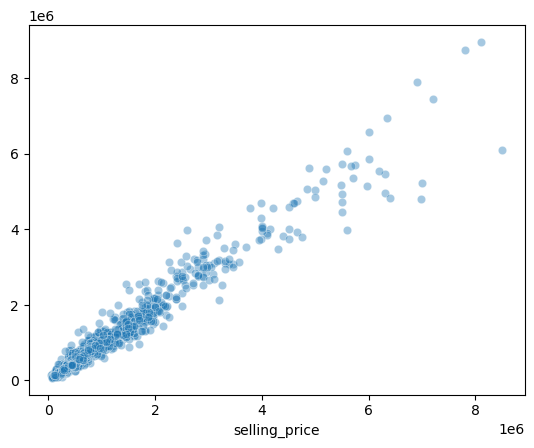

In [16]:
sb.scatterplot(y_test, y_pred_test, alpha=.4)

In [26]:
new_data_x = X_train.loc[128]
new_data_y = y_train.loc[128]
print(new_data_y)

770000


In [18]:
scaled_new_data = std_scaler.transform([new_data_x])

In [19]:
rfr.predict(scaled_new_data)

array([742440.])

In [20]:
columns_names = {'columns':[col for col in X.columns]}

In [21]:
with open('columns.json', 'w') as f:
    f.write(json.dumps(columns_names))

In [22]:
with open('used_cars.pickle', 'wb') as f:
    pickle.dump(rfr, f)

In [23]:
ndf = pd.read_csv('cardekho_imputated.csv')
test_csv = ndf.iloc[X_test.index].drop(['Unnamed: 0'], axis=1)

In [24]:
test_csv.to_csv('test_set.csv')